# Algorithm comparison

This notebook analyses the data generated with 00-Algorithms_comparison.ipynb. For the hierarchical and non-hierarchical configurations, it extracts different features: rewards, weights, L4-features and total remaining tim eon each server. 

## Imports

In [2]:
import re, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})
%matplotlib inline

def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth


## Experience configuration

In [3]:
experience = "Algorithms_comparison/"
rates = [0.9]
features = ['res_fct_avg_disc']

methods = [
    #=== rule ===#
    # "ecmp", # Equal-Cost Multi-Path (ECMP)
    # "wcmp", # Weighted-Cost Multi-Path (WCMP)
    "lsq", # Local shortest queue (LSQ)
    # "lsq2", # LSQ + power-of-2-choices
    "sed", # Shortest Expected Delay
    # "sed2", # LSQ + power-of-2-choices
    # "srt", # Shortest Remaining Time (SRT) (Layer-7)
    # "srt2", # SRT + power-of-2-choices
    #"gsq", # Global shortest queue (GSQ) (Layer-7)
    #"gsq2", # GSQ + power-of-2-choices·
    # "active-wcmp", # Spotlight, adjust weights based on periodic polling
    #=== heuristic ===#
    # "aquarius", # Aquarius, 
    # "hlb", # Hybrid LB (HLB), Aquarius replacing alpha by Kalman filter
    # "hlb2", # HLB + power-of-2-choices
    # "hlb-ada", # HLB + adaptive sensor error
    # "hermes", #hermes
    # "rs", # reservoir sampling #flow
    # "rs2", # reservoir sampling #flow + power-of-2
    # "geom", # geometry-based algorithm
    #"geom-w", # geometry-based algorithm
    # "prob-flow", # geometry-based algorithm
    #"prob-flow-w", # geometry-based algorithm
    # "prob-flow2", # geometry-based algorithm
    #"prob-flow-w2", # geometry-based algorithm
    #"geom-sed", # geometry-based algorithm
    #"geom-sed-w", # geometry-based algorithm
    # === reinforcement learning ===#
    "rlb-sac", # SAC model
    "rlb-sac-tiny", # SAC tiny-model
    # "rlb-sac-tiny2", # SAC tiny-model
]
methods_hierarchical = [
    # === Hierarchicak methods learning ===#
    'rlb-saclsq',
]

configs = [ 
    # (1,4), # 1LB, 4 servers
    # (1,16), # 1LB, 16 servers
    (1,64) # 1LB, 64 servers
]
configs_hierarchical = [
    (1,8,64), #1 primary LB, 8 secondary LBs, 6 servers
    # (1,4,16), #1 primary LB, 8 secondary LBs, 6 servers
    # (1,2,4), #1 primary LB, 8 secondary LBs, 6 servers
]


result1 = {} #Reward
result2 = {} #Total remaining time
result3 = {} #Features
result4 = {} #Weights
result5 = {} #Q-len list

## Extraction from files

In [4]:
for config in configs_hierarchical:
    result1[config] = {}
    result2[config] = {}
    result3[config] = {}
    result4[config] = {}
    result5[config] = {}
    for rate in rates:
        result1[config][rate] = {}
        result2[config][rate] = {}
        result3[config][rate] = {}
        result4[config][rate] = {}
        result5[config][rate] = {}
        for method in methods_hierarchical:
            n_lbp, n_lbs, n_as = config
            exp = experience + '{}lbp-{}lbs-{}as'.format(n_lbp, n_lbs, n_as)
            dirname = os.path.join("../data/simulation", exp, method, "rate{:.3f}".format(rate), "")
            filename = os.path.join(dirname, 'test.log')
            print(filename)
            
            try:
                all_lines = [l for l in read_file(filename)]
            except:
                all_lines = []
            start_idx = [1]
            end_idx = [i for i, l in enumerate(all_lines) if 'end of episode' in l]
            start_idx += end_idx[:-1]
            if len(start_idx) != len(end_idx):
                end_idx.append(len(all_lines)-1)
            n_ep = len(start_idx)

            reward_total = []
            reward_list={}
            t_rest_total_list = []
            feature_lists={}
            weights=[]

            for feature in features:
                feature_lists[feature]={}
                for i in range (1, n_lbs+1):
                    feature_lists[feature]['lb{}'.format(i)] = []
            for i in range (0, n_lbs+1):
                reward_list['lb{}'.format(i)] = []

            for ep in range(n_ep):
                reward_total+= [float(l.split(' ')[-1]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'Reward' in l]
                t_rest_total_list+= [float(l.split(' ')[-1]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'Remaining' in l]
                
                weights += [(map(float, re.findall("\d+\.\d+", l))[-n_lbs:]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'm ' in l]
                
                for i in range (0, n_lbs+1):
                    lines = [float(l.split(' ')[-1]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'Reward' in l and 'lb{}'.format(i) in l]
                    reward_list['lb{}'.format(i)] += lines
                for feature in features:
                    for i in range (1, n_lbs+1):
                        lines = [l.split()[-1] for l in all_lines[start_idx[ep]:end_idx[ep]] if feature in l and 'lb{}'.format(i) in l]
                        for l in lines:
                            l = [float(s) for s in l.split('|')]
                            feature_lists[feature]['lb{}'.format(i)].append(l)

            result1[config][rate][method] = reward_total
            result2[config][rate][method] = t_rest_total_list
            result3[config][rate][method] = feature_lists
            result4[config][rate][method] = weights



../data/simulation/Algorithms_comparison/1lbp-8lbs-64as/rlb-saclsq/rate0.900/test.log


In [5]:
x = []
for config in configs:
    result1[config] = {}
    result2[config] = {}
    result3[config] = {}
    result4[config] = {}
    result5[config] = {}
    for rate in rates:
        result1[config][rate] = {}
        result2[config][rate] = {}
        result3[config][rate] = {}
        result4[config][rate] = {}
        result5[config][rate] = {}
        for method in methods:
            n_lb, n_as = config
            exp = experience + '{}lb-{}as'.format(n_lb, n_as)
            dirname = os.path.join("../data/simulation", exp, method, "rate{:.3f}".format(rate), "")
            filename = os.path.join(dirname, 'test.log')
            print(filename)
            
            try:
                all_lines = [l for l in read_file(filename)]
            except:
                all_lines = []
        
            start_idx = [1]
            end_idx = [i for i, l in enumerate(all_lines) if 'end of episode' in l]
            start_idx += end_idx[:-1]
            if len(start_idx) != len(end_idx):
                end_idx.append(len(all_lines)-1)
            n_ep = len(start_idx)

            reward_total = []
            t_rest_total_list = []
            feature_lists={}
            weights=[]

            for feature in features:
                feature_lists[feature]=[]
            for ep in range(n_ep):
                reward_total+= [float(l.split(' ')[-1]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'Reward' in l]
                t_rest_total_list+= [float(l.split(' ')[-1]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'Remaining' in l] 
                weights += [(map(float, re.findall("\d+\.\d*", l))[-n_as:]) for l in all_lines[start_idx[ep]:end_idx[ep]] if 'm ' in l]

                for feature in features:
                    try:
                        for l in all_lines[start_idx[ep]:end_idx[ep]]:
                            if feature in l:
                                # print(l)
                                tab = l.split('= ')[-1]
                                x = ast.literal_eval(tab)
                                feature_lists[feature].append(x)
                    except: pass            
            result1[config][rate][method] = reward_total
            result2[config][rate][method] = t_rest_total_list
            result3[config][rate][method] = feature_lists
            result4[config][rate][method] = weights

../data/simulation/Algorithms_comparison/1lb-64as/lsq/rate0.900/test.log
../data/simulation/Algorithms_comparison/1lb-64as/sed/rate0.900/test.log
../data/simulation/Algorithms_comparison/1lb-64as/rlb-sac/rate0.900/test.log
../data/simulation/Algorithms_comparison/1lb-64as/rlb-sac-tiny/rate0.900/test.log


## Results

### Reward ( Jain index -1 )

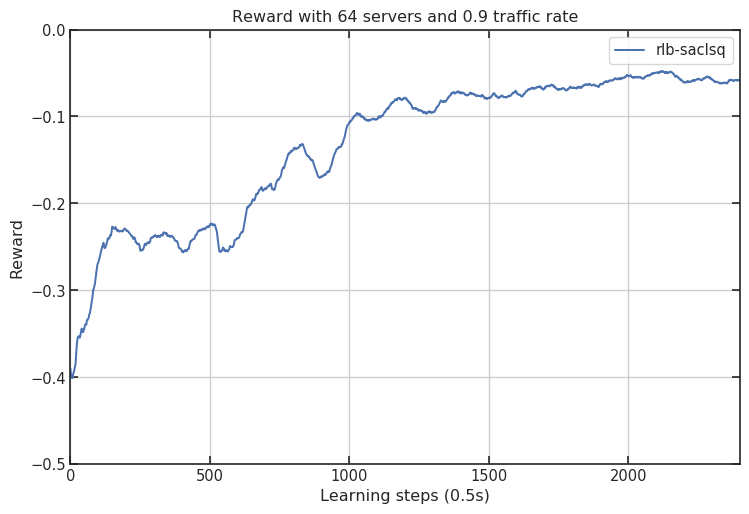

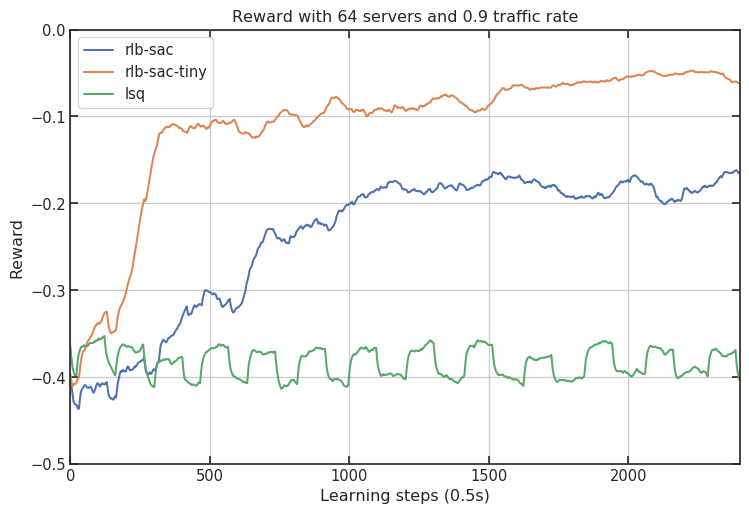

In [6]:

for config, values1 in result1.items():
    for rate, values2 in values1.items():
        fig = plt.figure(figsize=(9, 6), dpi=96)
        plt.xlabel('Learning steps (0.5s)')
        plt.ylabel('Reward')
        for method, values3 in values2.items():
            try:
                plt.plot(smooth(values3, 100), label = method)  
            except: pass

        # plt.legend(['Hierarchical','LSQ', 'Classic RL'], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', mode="expand", borderaxespad=0.)
        # for t_end in [120, 250, 390, 540, 700, 870, 1050, 1240, 1440, 1650, 1870, 2100, 2340, 2590, 2850, 3120, 3400, 3690, 3990, 4300, 4620]:
        #     plt.plot([t_end]*30, np.arange(-1, 2, 0.1), '--', color='grey', label='_nolegend_')
        
        plt.ylim(-0.5, 0)
        plt.xlim(0, 2400)
        plt.title('Reward with {} servers and {} traffic rate'.format(config[-1], rate))
        plt.legend()
        plt.show()

### Assigned weights

<Figure size 432x288 with 0 Axes>

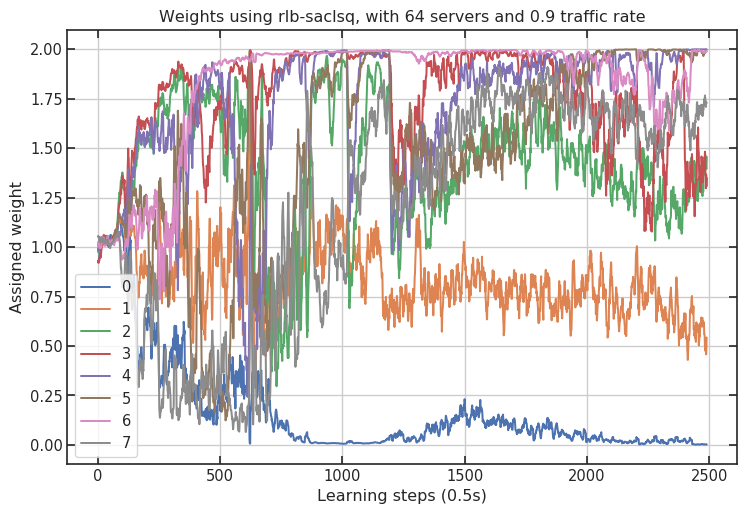

<Figure size 432x288 with 0 Axes>

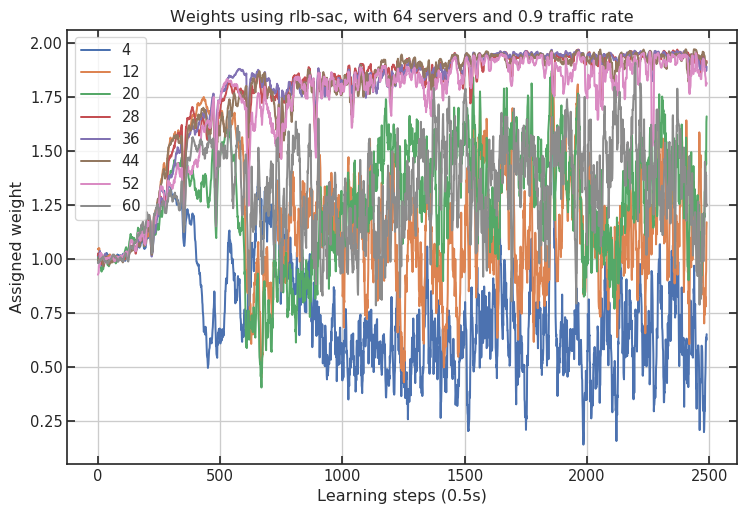

<Figure size 432x288 with 0 Axes>

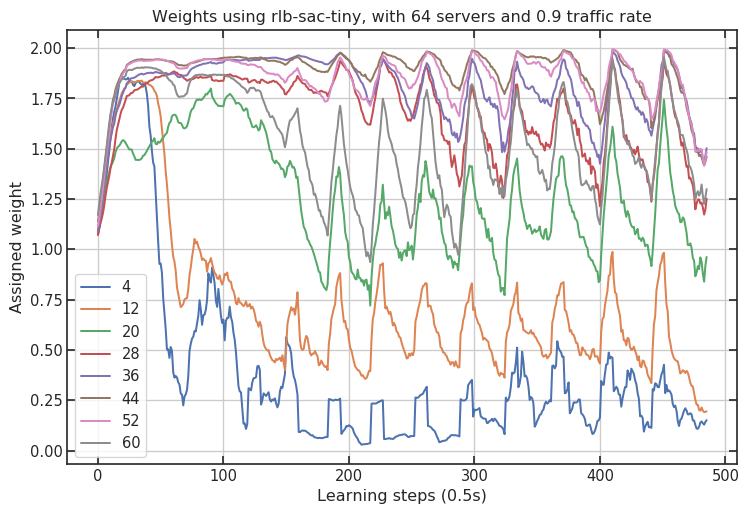

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [7]:
for config, values1 in result4.items():
    for rate, values2 in values1.items():
        for method, values3 in values2.items():
            plt.clf()
            fig = plt.figure(figsize=(9, 6), dpi=96)
            plt.xlabel('Learning steps (0.5s)')
            plt.ylabel('Assigned weight')
            plt.title('Weights using {}, with {} servers and {} traffic rate'.format(method, config[-1], rate))

            if method == 'rlb-sac-tiny':
                for j in range(len(values3)/n_as):
                    for i in range(n_as):
                        a = (values3[i+j*n_as])
                        if len(a) != 1 : print(a)
                a = [[values3[i+j*n_as][0] for i in range (n_as)] for j in range(len(values3)/n_as)]
                values3 = a
            try:
                if len(config) == 3:
                    for i in range (config[-2]):
                        plt.plot(smooth([m[i] for m in values3[:2500]], 10), label=i)
                    plt.legend()
                    plt.show()
                if len(config) == 2:
                    for i in range (config[-1]):
                        if not i%8 == 4: continue
                        plt.plot(smooth([m[i] for m in values3[:2500]], 10), label=i)
                    plt.legend()
                    plt.show()
            except Exception as e: pass
            plt.clf()



### Features

<Figure size 864x576 with 0 Axes>

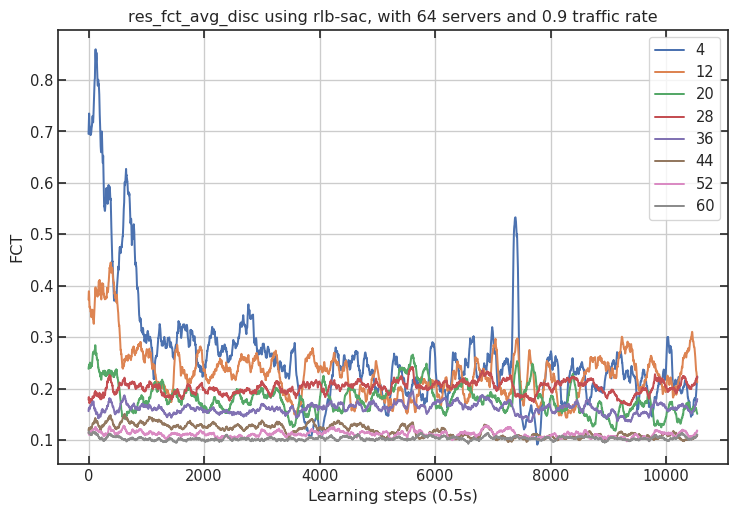

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [11]:
for config, values1 in result3.items():
    for rate, values2 in values1.items():
        for method, values3 in values2.items():
            for feature in features:
                try:
                    fig = plt.figure(figsize=(9, 6), dpi=96)
                    for i in range(n_as):
                        if not i%8 == 4: continue

                        plt.plot(smooth([m[i] for m in values3[feature]], 100), label=i)  

                    # plt.legend(['Hierarchical','LSQ', 'Classic RL'], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', mode="expand", borderaxespad=0.)
                    # for t_end in [120, 250, 390, 540, 700, 870, 1050, 1240, 1440, 1650, 1870, 2100, 2340, 2590, 2850, 3120, 3400, 3690, 3990, 4300, 4620]:
                    #     plt.plot([t_end]*30, np.arange(-1, 2, 0.1), '--', color='grey', label='_nolegend_')
                    plt.title('{} using {}, with {} servers and {} traffic rate'.format(feature, method, config[-1], rate))
                    plt.legend()
                    # plt.ylim(0, 2)
                    # plt.xlim(0, 2400)
                    plt.xlabel('Learning steps (0.5s)')
                    plt.ylabel('FCT')
                    plt.show()
                except: pass
